# Introduction

### Import the libraries

In [117]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#useful tools
from sklearn.model_selection import cross_validate
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

'''
Sub-objective: The preprocessing and feature extraction process uses one single simulated core only, which is slow. Might be worth
enhancing parallelism if time allows
'''

'\nSub-objective: The preprocessing and feature extraction process uses one single simulated core only, which is slow. Might be worth\nenhancing parallelism if time allows\n'

### Notebook display settings

In [51]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings("ignore")

### Default figure settings

In [52]:
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titleweight']='bold'
mpl.rcParams['axes.labelweight']='normal'
mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"

### Get the number of cpu

In [53]:
import multiprocessing as mp
n_cpu=mp.cpu_count()

# Data Transformation & Exploration

### Read the data

In [54]:
training_data=pd.read_csv('Data/epl-training.csv')
data = training_data # delete these additional refs later

# Dropping the trailing columns
training_data.dropna(axis=1, how='all',inplace=True)
training_data.drop([column for column in training_data.columns if 'Unnamed' in column], axis = 1, inplace=True) 
#print('shape: ', training_data.shape)

#check about the datatypes, some attributes are needed to be encoded for the subsequent processes.
training_data.dtypes

training_data.shape

(4180, 22)

In [55]:
training_data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/2008,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/2008,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/2008,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/2008,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/2008,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0


### Exploratory Data Analysis

In [56]:
def get_pivot_column_vs_column_count(df,col1,col2):
    return df.groupby([col1,col2]).size().reset_index().\
              rename(columns={0:'counts'}).\
              pivot(values='counts',index=col1,columns=col2)

In [57]:
def get_column_countplot(df,col,y='FTR',ax=None ):
    if ax is None:
        ax = plt.gca()
    df.groupby([col, y]).size().reset_index().\
       pivot(columns=y, index=col, values=0).\
       plot(kind='bar', stacked=True,ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Counts')
    ax.set_title('Count Plot: %s'%(col))

#### Number of matches

In [58]:
get_pivot_column_vs_column_count(training_data,'HomeTeam','AwayTeam')

AwayTeam,Arsenal,Aston Villa,Birmingham,Blackburn,Blackpool,Bolton,Bournemouth,Brighton,Burnley,Cardiff,Chelsea,Crystal Palace,Everton,Fulham,Huddersfield,Hull,Leicester,Liverpool,Man City,Man United,Middlesbrough,Newcastle,Norwich,Portsmouth,QPR,Reading,Southampton,Stoke,Sunderland,Swansea,Tottenham,Watford,West Brom,West Ham,Wigan,Wolves
HomeTeam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arsenal,NaN,8.0,2.0,4.0,1.0,4.0,4.0,2.0,5.0,2.0,11.0,6.0,11.0,7.0,2.0,5.0,5.0,11.0,11.0,11.0,2.0,9.0,4.0,2.0,3.0,1.0,7.0,10.0,9.0,7.0,11.0,4.0,9.0,10.0,5.0,4.0
Aston Villa,8.0,NaN,2.0,4.0,1.0,4.0,1.0,NaN,2.0,1.0,8.0,3.0,8.0,6.0,NaN,4.0,2.0,8.0,8.0,8.0,1.0,7.0,4.0,2.0,3.0,1.0,4.0,8.0,8.0,5.0,8.0,1.0,7.0,7.0,5.0,3.0
Birmingham,2.0,2.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN,2.0,NaN,2.0,2.0,NaN,1.0,NaN,2.0,2.0,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,1.0,2.0,2.0,2.0
Blackburn,4.0,4.0,2.0,NaN,1.0,4.0,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Blackpool,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0
Bolton,4.0,4.0,2.0,4.0,1.0,NaN,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Bournemouth,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,1.0,4.0,4.0,4.0,1.0,2.0,1.0,4.0,4.0,4.0,4.0,1.0,3.0,1.0,NaN,NaN,NaN,4.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,NaN,1.0
Brighton,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0,2.0,2.0,1.0,2.0,NaN,2.0,2.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,NaN,1.0
Burnley,5.0,2.0,1.0,1.0,NaN,1.0,3.0,2.0,NaN,1.0,5.0,4.0,5.0,2.0,2.0,3.0,4.0,5.0,5.0,5.0,1.0,3.0,NaN,1.0,1.0,NaN,4.0,4.0,3.0,3.0,5.0,3.0,3.0,5.0,1.0,2.0


### HTR vs. FTR

In [59]:
get_pivot_column_vs_column_count(training_data,'HTR','FTR')

FTR,A,D,H
HTR,,,
A,703,199,99
D,439,647,646
H,70,191,1186


In [60]:
cat_col_list=[x for x in training_data.columns\
              if x not in ['Date','HomeTeam','AwayTeam','Referee','FTR','HTR']]


In [61]:
cat_col_list = np.reshape(cat_col_list, (8, 2))

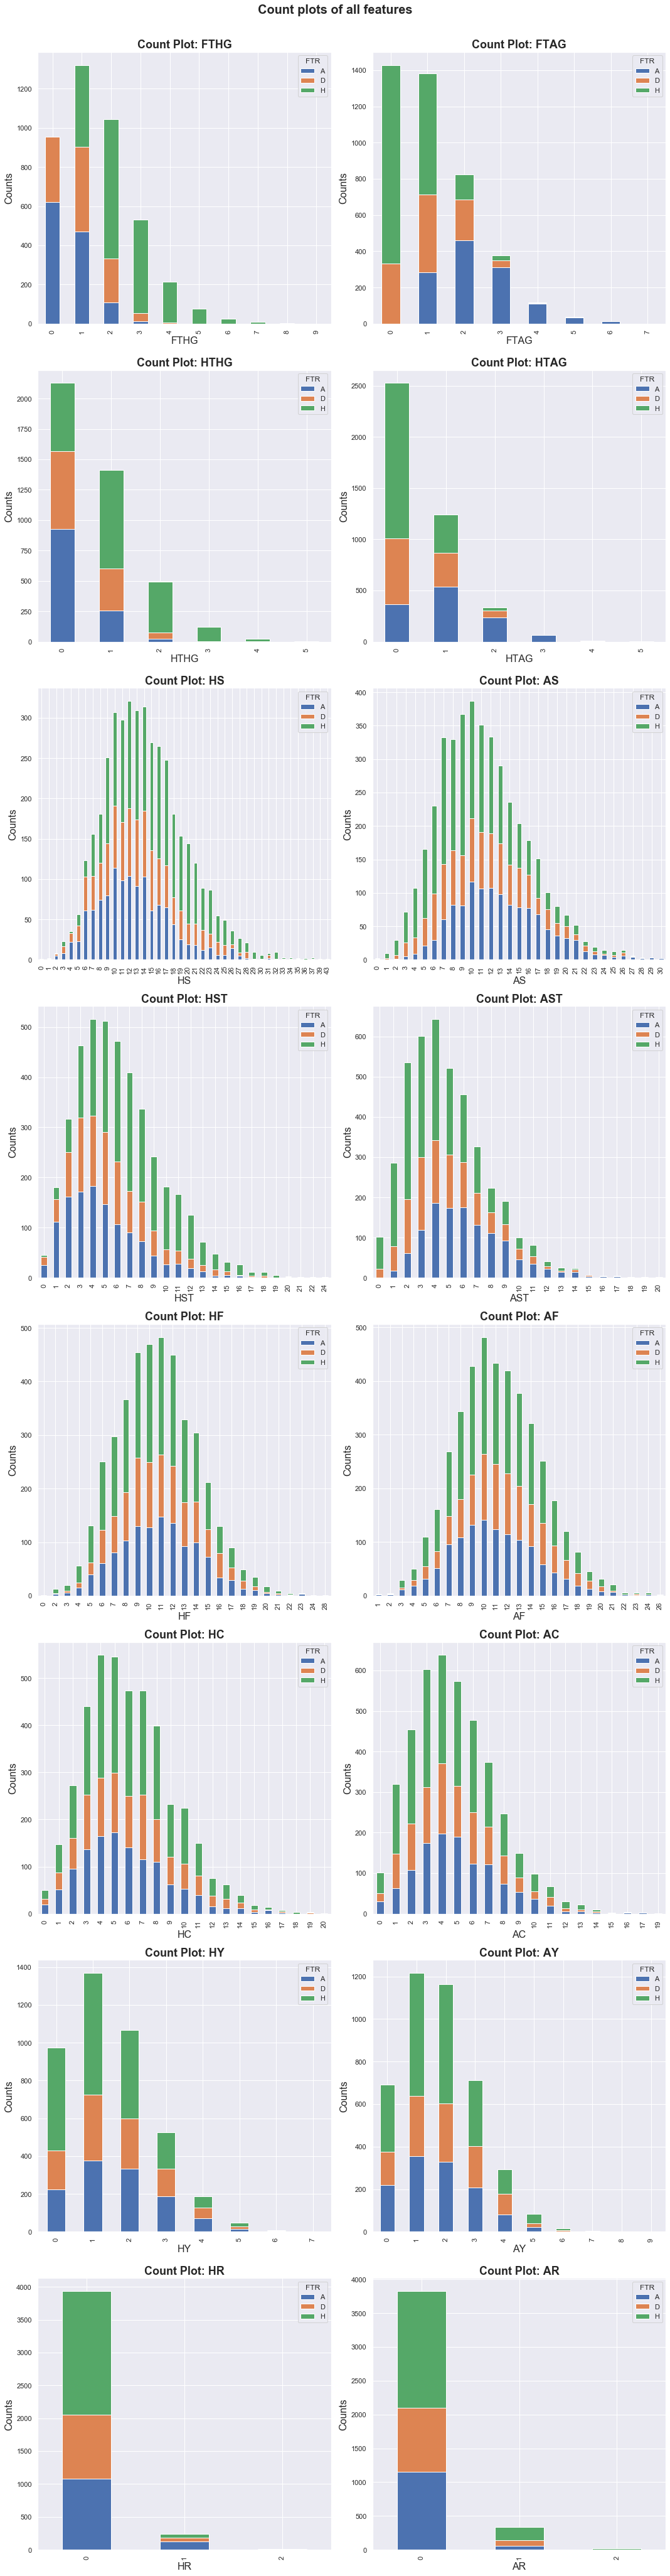

In [62]:
fig, axes = plt.subplots(8,2,figsize=(15,60))
for i in range(8):
    for j in range(2):
        get_column_countplot(training_data,cat_col_list[i][j], ax=axes[i,j])
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle("Count plots of all features",fontweight='bold',fontsize=20)
plt.show()

### Checking the dataset is balanced

In [63]:
count_val=training_data['FTR'].value_counts()

In [64]:
count_val

H    1931
A    1212
D    1037
Name: FTR, dtype: int64

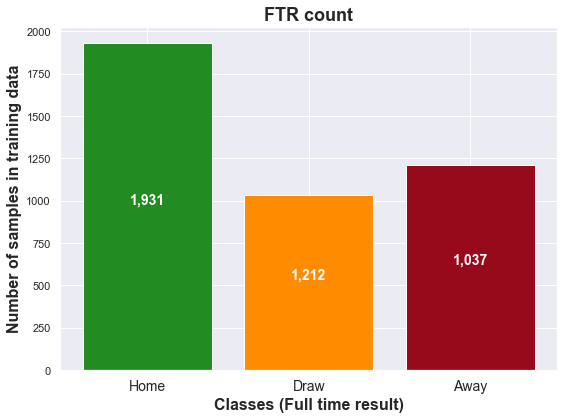

In [65]:
count_val=training_data['FTR'].value_counts()

#Visualising the count
X_ticks=['Home','Draw','Away']
bar_width=0.7
fig,ax=plt.subplots()
plt.bar(1,count_val[0],color='forestgreen')
plt.bar(2,count_val[2],color='darkorange')
plt.bar(3,count_val[1],color='#970a1b')
plt.text(1, count_val[0]/2, "{:,}".format(count_val[0]),color='w',
         ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(2, count_val[2]/2, "{:,}".format(count_val[1]), color='w'
         ,ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(3, count_val[1]/2, "{:,}".format(count_val[2]), color='w',
         ha='center', va= 'bottom',fontweight='bold',fontsize=14)
ax.set_title('FTR count',fontsize=18,fontweight='bold')
ax.set_xlabel('Classes (Full time result)',fontsize=16,fontweight='bold')
ax.set_ylabel('Number of samples in training data',fontsize=16,
              fontweight='bold')
ax.set_xticks([1,2,3])
ax.set_xticklabels(X_ticks,fontsize=14)
fig.tight_layout()
plt.show()

### Calculate the correlation between the features

In [66]:

correlation = data.corr()
corr_array  = np.array(correlation)

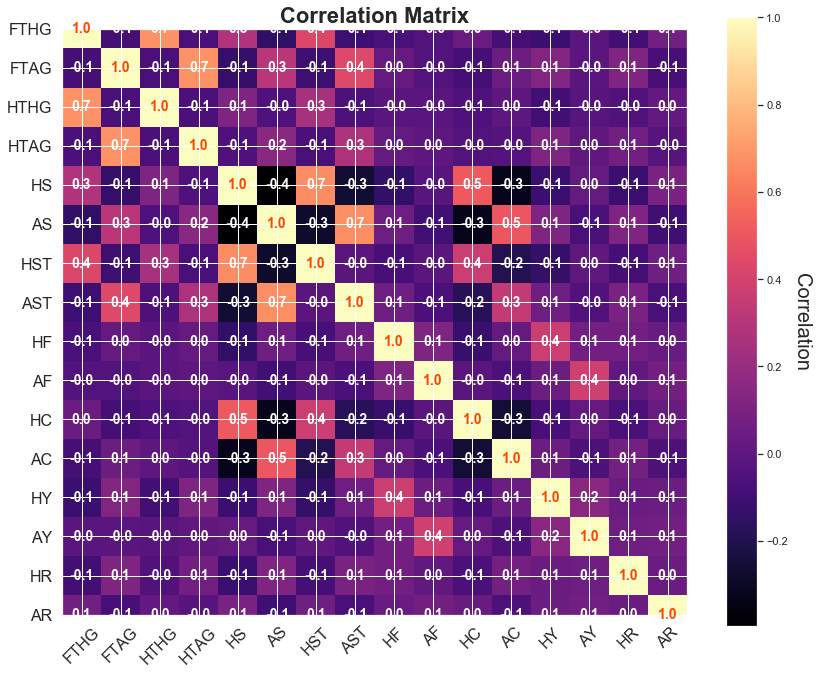

In [67]:
fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(corr_array,cmap='magma')
cbar = ax.figure.colorbar(im, ax=ax,shrink=0.8)
cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom",fontsize=20)
data = im.get_array()
textcolors=['#FFFFFF','#FF4500']
for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            text = im.axes.text(j, i, '%1.1f'%data[i, j], 
                                color=textcolors[data[i, j]>0.85],
                                ha='center',va='center',fontsize=14,fontweight='bold')
ax.set_title('Correlation Matrix',fontsize=22,fontweight='bold')
ax.set_xticks(np.arange(len(correlation.columns.tolist())))
ax.set_yticks(np.arange(len(correlation.columns)))
ax.set_xticklabels(correlation.columns,fontsize=16,rotation=45)
ax.set_yticklabels(correlation.columns,fontsize=16)
plt.show()

### My playing with data

In [68]:
#some functions
#trim too extreme data. (eg. super strong team vs super weak team and score alot)
def trim_df_data(df, q1 = 0.25, q2 = 0.75):
    Q1 = df.quantile(q1); Q3 = df.quantile(q2);
    IQR = Q3 - Q1
    df_trimmed = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_trimmed

number of duplicate rows:  (0, 22)
(2651, 22) (4180, 22)


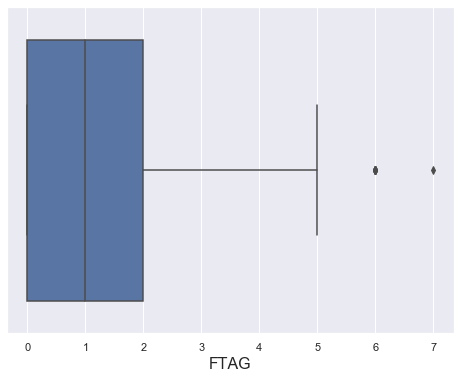

In [69]:
#chech the dataset has duplicate data
df = training_data.copy() # manipulate a copied data frame only!
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

#comfirming if there is null value from the dataset.
#print(df.isnull().sum()) #ans is no, so no need to consider policy dealing with them
sns.boxplot(x=df['FTAG'])

df_trimmed = trim_df_data(df, q1=0.25, q2 = 0.75)
print(df_trimmed.shape, df.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


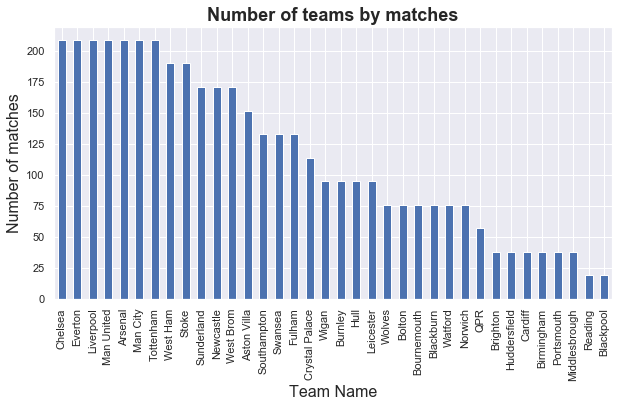

In [70]:
# checking for unbalanced data by teams
df.HomeTeam.value_counts().plot(kind='bar', figsize=(10,5))
plt.title('Number of teams by matches')
plt.ylabel('Number of matches')
plt.xlabel('Team Name');
print(type(df), type(df['FTR']))

### apply transformation for the FTR results

In [71]:
def encodeHDA(e):
    if(e == 'H'):
        return 1
    elif(e == 'A'):
        return -1
    elif(e == 'D'):
        return 0
    else:
         pass

In [72]:
#map the FTR and HTR to {-1,0,1} unbias classes
df['FTR'] = df['FTR'].map(lambda x: encodeHDA(x))
df['HTR'] = df['HTR'].map(lambda x: encodeHDA(x))

df.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
4175,12/05/2019,Liverpool,Wolves,2,0,1,1,0,1,M Atkinson,13,7,5,2,3,11,4,1,0,2,0,0
4176,12/05/2019,Man United,Cardiff,0,2,-1,0,1,-1,J Moss,26,13,10,4,9,6,11,2,3,3,0,0
4177,12/05/2019,Southampton,Huddersfield,1,1,0,1,0,1,L Probert,10,10,3,3,8,6,4,3,0,1,0,0
4178,12/05/2019,Tottenham,Everton,2,2,0,1,0,1,A Marriner,11,17,3,9,10,13,7,4,0,2,0,0
4179,12/05/2019,Watford,West Ham,1,4,-1,0,2,-1,C Kavanagh,17,16,8,9,10,10,7,2,1,0,1,0


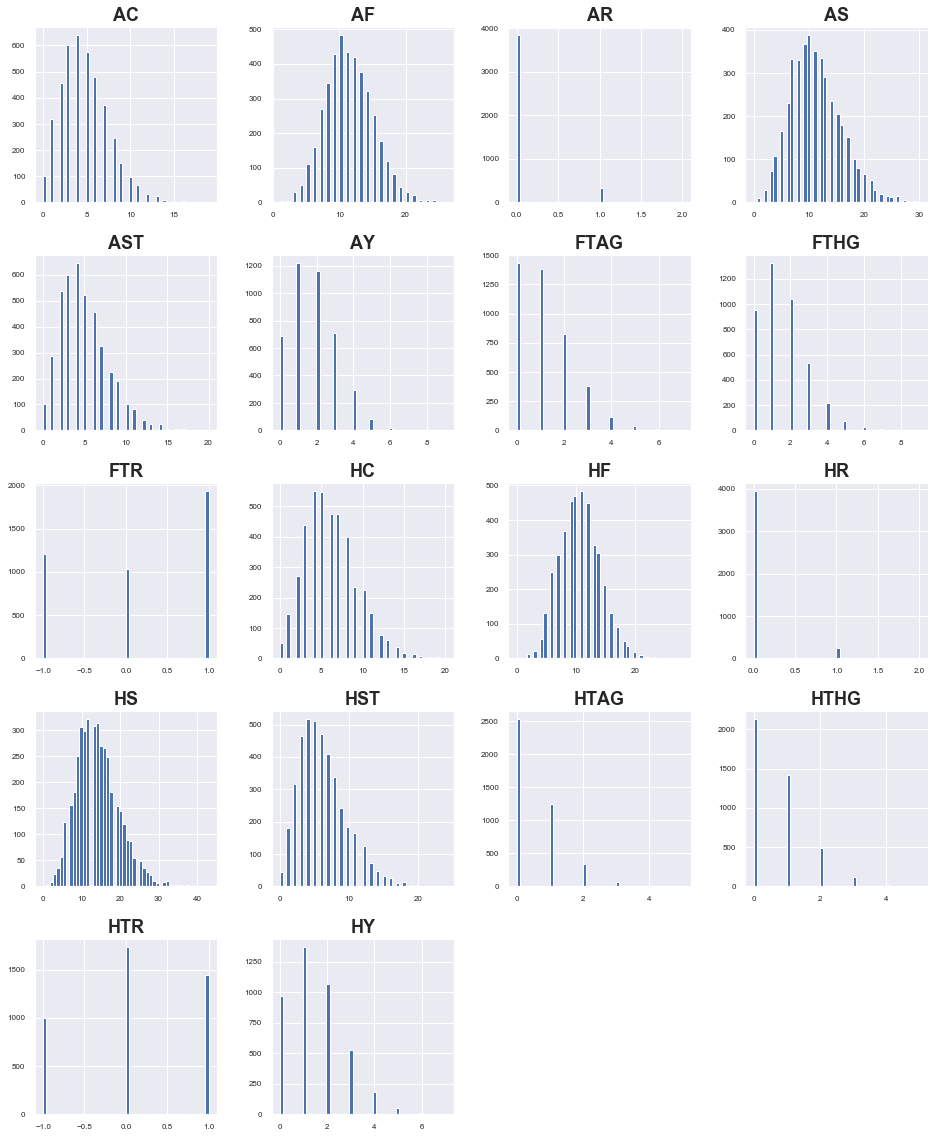

In [73]:
# print(df['HomeTeam'].describe())
#select numerical data
df_num = df.select_dtypes(include = ['int64'])

#plot the histogram of data for a sense of how they distribute
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [74]:
# They 
COR_TO_VAR = 'FTR'
df_num_corr = df_num.corr()[COR_TO_VAR]
df_num_corr = df_num_corr.drop(labels = [COR_TO_VAR])

# print(df_num_corr)
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("Number of strongly correlated values:{}\nThey are\n{}".format(len(golden_features_list), golden_features_list))


# Don't use the plot below, the data features are discrete and can't be shown very well.
# Consider HEATMAP instead
# for i in range(0, len(df_num.columns), 5):
#     sns.pairplot(data=df_num,
#                 x_vars=df_num.columns[i:i+5],
#                 y_vars=['FTR'])

Number of strongly correlated values:3
They are
FTHG    0.621950
HTR     0.610400
FTAG   -0.640924
Name: FTR, dtype: float64


# Feature Engineering

In [75]:
X=training_data[[column for column in training_data.columns if column != 'FTR']]
Y=training_data['FTR']

print(X.shape) #The overall shape of the training data
total_matches = X.shape[0] #Get total number of matches
average_home_goals = X.FTHG.sum()/ total_matches #Sum home goals column, divide by total matches
average_away_goals = X.FTAG.sum() / total_matches #Sum away goals column, divide by total matches
print(average_home_goals)
print(average_away_goals)
avg_home_conceded = average_away_goals #Average conceded goals = Average of goals for opposite team
avg_away_conceded = avg_home_conceded
#Note that this is the average across ALL teams

X.head()

(4180, 21)
1.555023923444976
1.1708133971291865


,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/2008,Arsenal,West Brom,1,0,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/2008,Bolton,Stoke,3,1,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/2008,Everton,Blackburn,2,3,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/2008,Hull,Fulham,2,1,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/2008,Middlesbrough,Tottenham,2,1,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0


In [76]:
#We obtain a table just for the teams. Each team has attributes Home 
table = pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS'))
res_home = X.groupby('HomeTeam')
res_away = X.groupby('AwayTeam')
all_teams_list = list(res_home.groups.keys())

print(all_teams_list)
table.Team = list(all_teams_list)
table.HGS = res_home.FTHG.sum().values #Home goal score
table.HGC = res_home.FTAG.sum().values #Home goal conceded
table.AGS = res_away.FTAG.sum().values #Away goal score
table.AGC = res_away.FTHG.sum().values #Away goal conceded

total_home_games_played = res_home.FTHG.count()
total_away_games_played = res_away.FTAG.count()

#Home Attacking Strength
table.HAS = (np.divide(table.HGS,total_home_games_played.values)) / average_home_goals
#Away Attacking Strength
table.AAS = (np.divide(table.AGS,total_away_games_played.values)) / average_away_goals
#Home Defence Strength
table.HDS = (np.divide(table.HGC,total_home_games_played.values)) / avg_home_conceded
#Away Defence Strength
table.ADS = (np.divide(table.AGC,total_away_games_played.values)) / avg_away_conceded

table.head()

['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Brighton', 'Burnley', 'Cardiff', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Middlesbrough', 'Newcastle', 'Norwich', 'Portsmouth', 'QPR', 'Reading', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wolves']


,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS
0,Arsenal,441,356,1.356923,1.454843,174,292,0.711075,1.193298
1,Aston Villa,179,156,0.757308,0.876584,198,264,1.112587,1.483449
2,Birmingham,38,37,0.643077,0.831631,35,70,0.786678,1.573355
3,Blackburn,98,77,0.829231,0.865345,90,162,1.011443,1.820597
4,Blackpool,30,25,1.015385,1.123825,37,41,1.663261,1.843073


In [77]:
#Home Shots on Target(HST), Away Shots on Target(AST), Home Corners(HC), Away Corners(AC)
#Home Attacking Strength(HAS), Home Defensive Strength(HDS), Away Attacking Strength(AAS), Away Defensive Strength(ADS)
f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []
for index,row in X.iterrows():
    f_HAS.append(table[table['Team'] == row['HomeTeam']]['HAS'].values[0])
    f_HDS.append(table[table['Team'] == row['HomeTeam']]['HDS'].values[0])
    f_AAS.append(table[table['Team'] == row['AwayTeam']]['AAS'].values[0])
    f_ADS.append(table[table['Team'] == row['AwayTeam']]['ADS'].values[0])

X['HAS'] = f_HAS
X['HDS'] = f_HDS
X['AAS'] = f_AAS
X['ADS'] = f_ADS

X

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HAS,HDS,AAS,ADS
0,16/08/2008,Arsenal,West Brom,1,0,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,1.356923,0.711075,0.769196,1.358580
1,16/08/2008,Bolton,Stoke,3,1,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,0.880000,1.292399,0.674295,1.402534
2,16/08/2008,Everton,Blackburn,2,3,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,1.101538,0.919493,0.865345,1.820597
3,16/08/2008,Hull,Fulham,2,1,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,0.724308,1.303637,0.667873,1.387121
4,16/08/2008,Middlesbrough,Tottenham,2,1,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,0.575385,0.966490,1.356763,1.144258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,12/05/2019,Liverpool,Wolves,2,0,1,0,H,M Atkinson,13,7,5,2,3,11,4,1,0,2,0,0,1.350769,0.702902,0.842869,1.505926
4176,12/05/2019,Man United,Cardiff,0,2,0,1,A,J Moss,26,13,10,4,9,6,11,2,3,3,0,0,1.338462,0.678382,0.561913,1.573355
4177,12/05/2019,Southampton,Huddersfield,1,1,1,0,H,L Probert,10,10,3,3,8,6,4,3,0,1,0,0,0.957363,1.021075,0.539436,1.753167
4178,12/05/2019,Tottenham,Everton,2,2,1,0,H,A Marriner,11,17,3,9,10,13,7,4,0,2,0,0,1.156923,0.731508,0.984879,1.136085


In [78]:
#Some additional features: 
# - Average goals of home team in the past n matches against the away team
# - Average goals of away team in past n matches against home team
# - Average points of away team in the past n matches against the home team

n_matches = len(X)
average_home_points = (3*sum(Y == 'H') + sum(Y == 'D'))/n_matches
average_away_points = (3*sum(Y == 'A') + sum(Y == 'D'))/n_matches
print(average_home_goals)
print(average_away_goals)
print(average_home_points)
print(average_away_points)

1.555023923444976
1.1708133971291865
1.6339712918660287
1.1179425837320573


In [79]:
def get_features_match(match, n=5):
    team1 = match['HomeTeam']
    team2 = match['AwayTeam']
    # Constructing a table when all the matches between the two teams are shown.
    res = X[((X['HomeTeam']==team1) & (X['AwayTeam']==team2)) | ((X['AwayTeam']==team1) & (X['HomeTeam']==team2))]
    name = match.name
    idx = res.index.get_loc(name)
    if idx >= n: #If there is at least n matches between the teams
        matches = res.iloc[idx-n:idx]
        pts_home = 0
        goals_home = 0
        goals_away = 0
        for index, row in matches.iterrows():
            #This ifs control if the current home team was home team or away in the past matches between the team in order
            #to sum correctly home/away goals. 
            if row['HomeTeam'] == team1:
                goals_home += row['FTHG']
                goals_away += row['FTAG']
                if Y[index] == 'H':
                    pts_home += 3
                elif Y[index] == 'D':
                    pts_home += 1
            if row['AwayTeam'] == team1:
                goals_home += row['FTAG'] 
                goals_away += row['FTHG']
                if Y[index] == 'A':
                    pts_home += 3
                elif Y[index] == 'D':
                    pts_home += 1
        pts_avg = pts_home/n
        goals_home_avg = goals_home/n
        goals_away_avg = goals_away/n
    elif idx == 0: # If there is 0 matches between the teams
        pts_avg = 1.6450138504155125
        goals_home_avg = 1.5336565096952908
        goals_away_avg = 1.1425207756232687
    else: #Some games between the teams but not n
        matches = res.iloc[0:idx]
        m = len(matches)
        pts_home = 0
        goals_home = 0
        goals_away = 0
        for index, row in matches.iterrows():
            #This ifs control if the current home team was home team or away in the past matches between the team in order
            #to sum correctly home/away goals. 
            if row['HomeTeam'] == team1:
                goals_home += row['FTHG']
                goals_away += row['FTAG']
                if Y[index] == 'H':
                    pts_home += 3
                elif Y[index] == 'D':
                    pts_home += 1
            if row['AwayTeam'] == team1:
                goals_home += row['FTAG'] 
                goals_away += row['FTHG']
                if Y[index] == 'A':
                    pts_home += 3
                elif Y[index] == 'D':
                    pts_home += 1
        pts_avg = pts_home/m
        goals_home_avg = goals_home/m
        goals_away_avg = goals_away/m
    return pts_avg, goals_home_avg, goals_away_avg

In [80]:
pts_avgs = []
goals_home_avgs = []
goals_away_avgs = []
for index, row in X.iterrows():
    pts_avg, goals_home_avg, goals_away_avg = get_features_match(row, n=5)
    pts_avgs.append(pts_avg)
    goals_home_avgs.append(goals_home_avg)
    goals_away_avgs.append(goals_away_avg)


feature_table = X # reference ft to X FOR TMP SIMPLE USE ONLY. REMEMBER TO DELETE LATER !!!

In [81]:
feature_table['FFPTSH'] = pts_avgs
feature_table['FFHG'] = goals_home_avgs
feature_table['FFAG'] = goals_away_avgs 

In [82]:
feature_table.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HAS,HDS,AAS,ADS,FFPTSH,FFHG,FFAG
0,16/08/2008,Arsenal,West Brom,1,0,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,1.356923,0.711075,0.769196,1.358580,1.645014,1.533657,1.142521
1,16/08/2008,Bolton,Stoke,3,1,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,0.880000,1.292399,0.674295,1.402534,1.645014,1.533657,1.142521
2,16/08/2008,Everton,Blackburn,2,3,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,1.101538,0.919493,0.865345,1.820597,1.645014,1.533657,1.142521
3,16/08/2008,Hull,Fulham,2,1,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,0.724308,1.303637,0.667873,1.387121,1.645014,1.533657,1.142521
4,16/08/2008,Middlesbrough,Tottenham,2,1,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,0.575385,0.966490,1.356763,1.144258,1.645014,1.533657,1.142521


In [83]:
#Extract features relating to form. Form is defined as a team's recent performance, e.g. recently 
#winning many matches.


#We can also look at whether a team is also "streaking" i.e. winning matches consecutively.

def get_features_streak_home(match, n=10):
    team1 = match['HomeTeam']
    team1_stats = X[((X['HomeTeam']==team1) | (X['AwayTeam']==team1))]
    name = match.name
    idx = team1_stats.index.get_loc(name)
    if idx == 0:
        pts_avg = 1.6450138504155125
        goals_scored_avg = 1.5336565096952908
        goals_conceded_avg = 1.1425207756232687
    else:
        if idx-n < 0:
            newidx = 0
        else:
            newidx = idx - n
        matches_team1 = team1_stats.iloc[newidx:idx]
        m = len(matches_team1)
        pts = 0
        goals_scored = 0
        goals_conceded = 0
        for index, row in matches_team1.iterrows():
            if row['HomeTeam'] == team1:
                goals_scored += row['FTHG']
                goals_conceded += row['FTAG']
                if Y[index] == 'H':
                    pts += 3
                elif Y[index] == 'D':
                    pts += 1
            if row['AwayTeam'] == team1:
                goals_scored += row['FTAG'] 
                goals_conceded += row['FTHG']
                if Y[index] == 'A':
                    pts += 3
                elif Y[index] == 'D':
                    pts += 1
        pts_avg = pts/m
        goals_scored_avg = goals_scored/m
        goals_conceded_avg = goals_conceded/m
    return pts_avg, goals_scored_avg, goals_conceded_avg

#Seeing if it works for a given match
match = X.iloc[1234,:]
get_features_streak_home(match, n=10)


pts_streak_home = []
goals_scored_streak_home = []
goals_conceded_streak_home = []
for index, row in X.iterrows():
    pt_streak_home, goal_scored_streak_home, goal_conceded_streak_home = get_features_streak_home(row, n=15)
    pts_streak_home.append(pt_streak_home)
    goals_scored_streak_home.append(goal_scored_streak_home)
    goals_conceded_streak_home.append(goal_conceded_streak_home)
print(len(pts_streak_home))

feature_table['PSH'] = pts_streak_home
feature_table['SSH'] = goals_home_avgs
feature_table['CSH'] = goals_away_avgs 
feature_table.tail()

feature_table.head()

def get_features_streak_away(match, n=10):
    team1 = match['AwayTeam']
    team1_stats = X[((X['HomeTeam']==team1) | (X['AwayTeam']==team1))]
    name = match.name
    idx = team1_stats.index.get_loc(name)
    if idx == 0:
        pts_avg = 1.1023545706371192
        goals_scored_avg = 1.1425207756232687
        goals_conceded_avg = 1.5336565096952908
    else:
        if idx-n < 0:
            newidx = 0
        else:
            newidx = idx - n
        matches_team1 = team1_stats.iloc[newidx:idx]
        m = len(matches_team1)
        pts = 0
        goals_scored = 0
        goals_conceded = 0
        for index, row in matches_team1.iterrows():
            if row['HomeTeam'] == team1:
                goals_scored += row['FTHG']
                goals_conceded += row['FTAG']
                if Y[index] == 'H':
                    pts += 3
                elif Y[index] == 'D':
                    pts += 1
            if row['AwayTeam'] == team1:
                goals_scored += row['FTAG'] 
                goals_conceded += row['FTHG']
                if Y[index] == 'A':
                    pts += 3
                elif Y[index] == 'D':
                    pts += 1
        pts_avg = pts/m
        goals_scored_avg = goals_scored/m
        goals_conceded_avg = goals_conceded/m
    return pts_avg, goals_scored_avg, goals_conceded_avg



pts_streak_away = []
goals_scored_streak_away = []
goals_conceded_streak_away = []
for index, row in X.iterrows():
    pt_streak_away, goal_scored_streak_away, goal_conceded_streak_away = get_features_streak_away(row, n=15)
    pts_streak_away.append(pt_streak_away)
    goals_scored_streak_away.append(goal_scored_streak_away)
    goals_conceded_streak_away.append(goal_conceded_streak_away)
len(pts_streak_home)



feature_table['PSA'] = pts_streak_away
feature_table['SSA'] = goals_scored_streak_away
feature_table['CSA'] = goals_conceded_streak_away


4180


In [84]:
feature_table.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HAS,HDS,AAS,ADS,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,16/08/2008,Arsenal,West Brom,1,0,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,1.356923,0.711075,0.769196,1.358580,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657
1,16/08/2008,Bolton,Stoke,3,1,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,0.880000,1.292399,0.674295,1.402534,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657
2,16/08/2008,Everton,Blackburn,2,3,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,1.101538,0.919493,0.865345,1.820597,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657
3,16/08/2008,Hull,Fulham,2,1,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,0.724308,1.303637,0.667873,1.387121,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657
4,16/08/2008,Middlesbrough,Tottenham,2,1,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,0.575385,0.966490,1.356763,1.144258,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657


In [85]:
# # TODO: implement later when season will be taken into consideration
# training_data['Date'] = pd.to_datetime(training_data['Date'],format='%d/%m/%Y')
# training_data['Month'] = training_data['Date'].dt.month 
# training_data['Year'] = training_data['Date'].dt.year

In [86]:
df = X.copy()
df['FTR'] = Y

df['FTR'] = df['FTR'].map(lambda x: encodeHDA(x))
df['HTR'] = df['HTR'].map(lambda x: encodeHDA(x))

df_num = df.select_dtypes(include = ['int64', 'float64']) # it selects new features only !
df_num.head()

,FTHG,FTAG,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HAS,HDS,AAS,ADS,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA,FTR
0,1,0,1,0,1,24,5,14,4,11,8,7,5,0,0,0,0,1.356923,0.711075,0.769196,1.358580,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657,1
1,3,1,3,0,1,14,8,8,2,13,12,4,3,1,2,0,0,0.880000,1.292399,0.674295,1.402534,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657,1
2,2,3,1,1,0,10,15,5,11,11,9,3,5,2,2,0,0,1.101538,0.919493,0.865345,1.820597,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657,-1
3,2,1,1,1,0,11,12,6,6,10,9,5,6,3,0,0,0,0.724308,1.303637,0.667873,1.387121,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657,1
4,2,1,0,0,0,14,8,10,5,11,12,7,9,1,2,0,0,0.575385,0.966490,1.356763,1.144258,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657,1


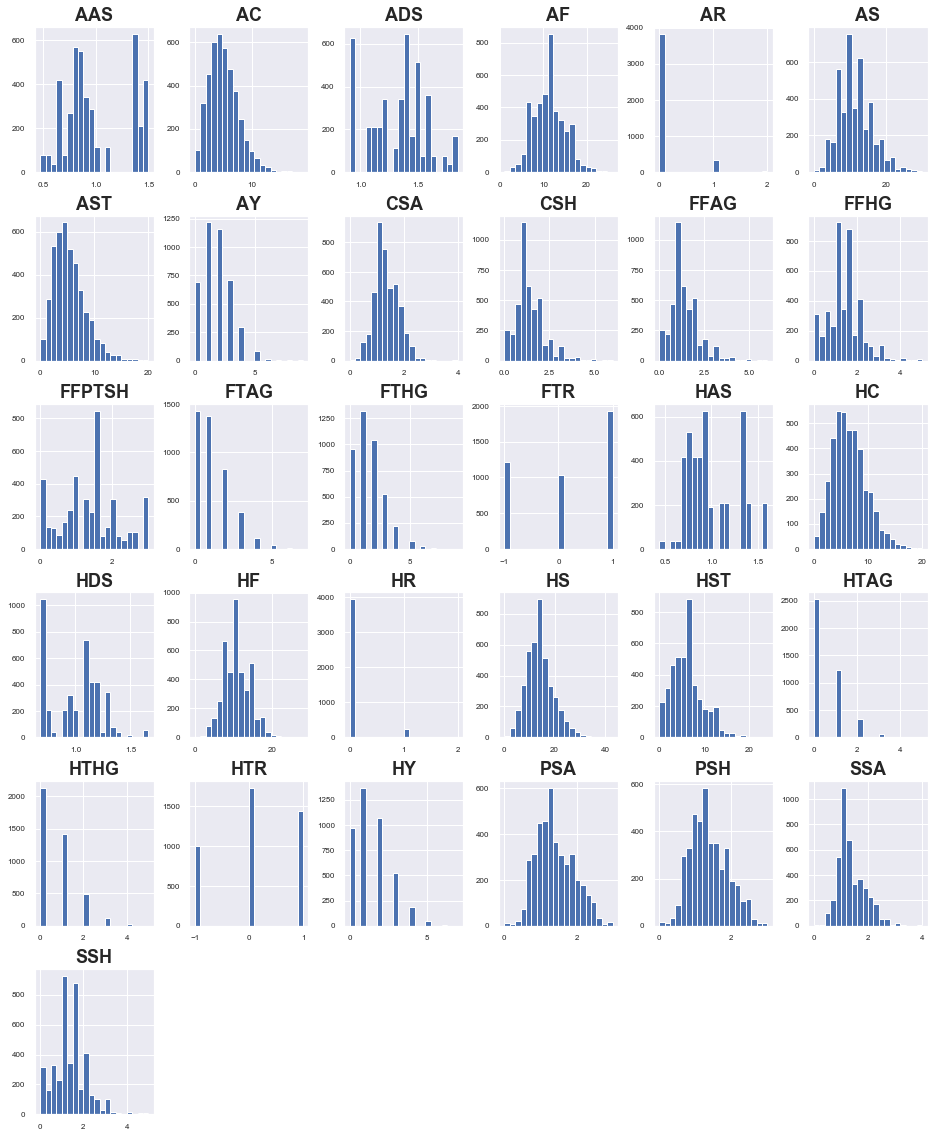

In [87]:
df_num.hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8);

In [88]:
# find correlated vals to feat, such as 'FTR'
def printMostCorFeat(df, toFeat, thresh = 0.5):
    df_corr = df.corr()[toFeat]
    
    featList = df_corr.drop(labels = [toFeat])[abs(df_corr) > thresh].sort_values(ascending=False)
    print("{} strongly correlated values\nThey are:\n{}".format(len(featList), featList))
    return None

printMostCorFeat(df_num, 'FTR', 0.5)

3 strongly correlated values
They are:
FTHG    0.621950
HTR     0.610400
FTAG   -0.640924
Name: FTR, dtype: float64


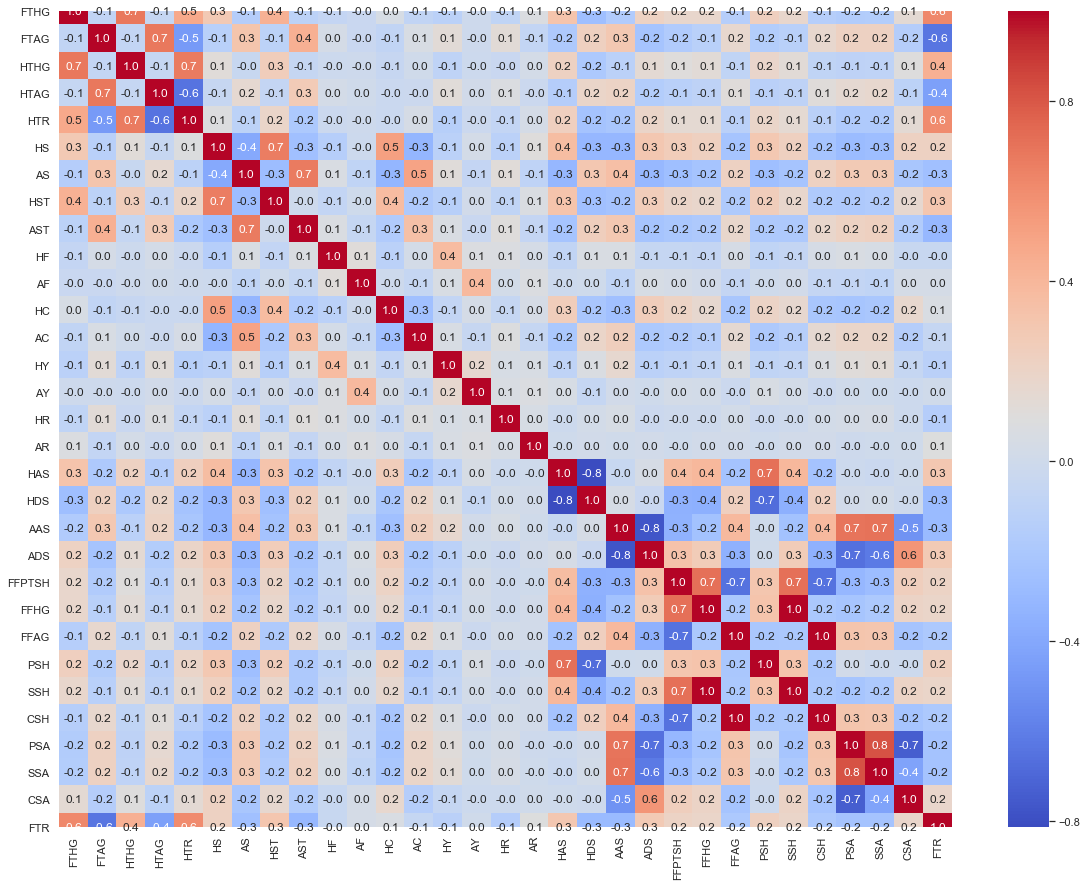

In [98]:
plt.figure(figsize=(20,15))
ax=plt.subplot(111)
sns.heatmap(df_num.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax)

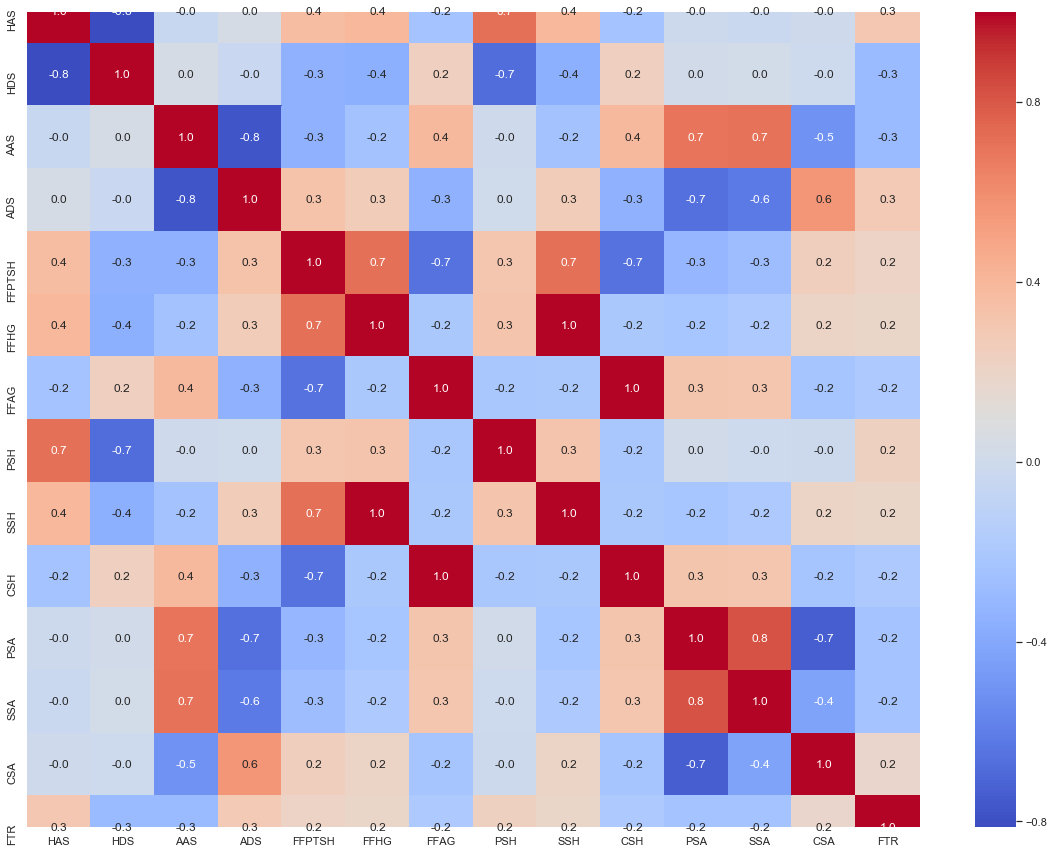

In [90]:
# find out new feats cor.

df_num_newFeat = df.select_dtypes(include = ['float64']) #only new feats are in float in df currently
df_num_newFeat['FTR'] = Y.map(lambda e: encodeHDA(e))
plt.figure(figsize=(20,15))
ax=plt.subplot(111)
sns.heatmap(df_num_newFeat.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax)

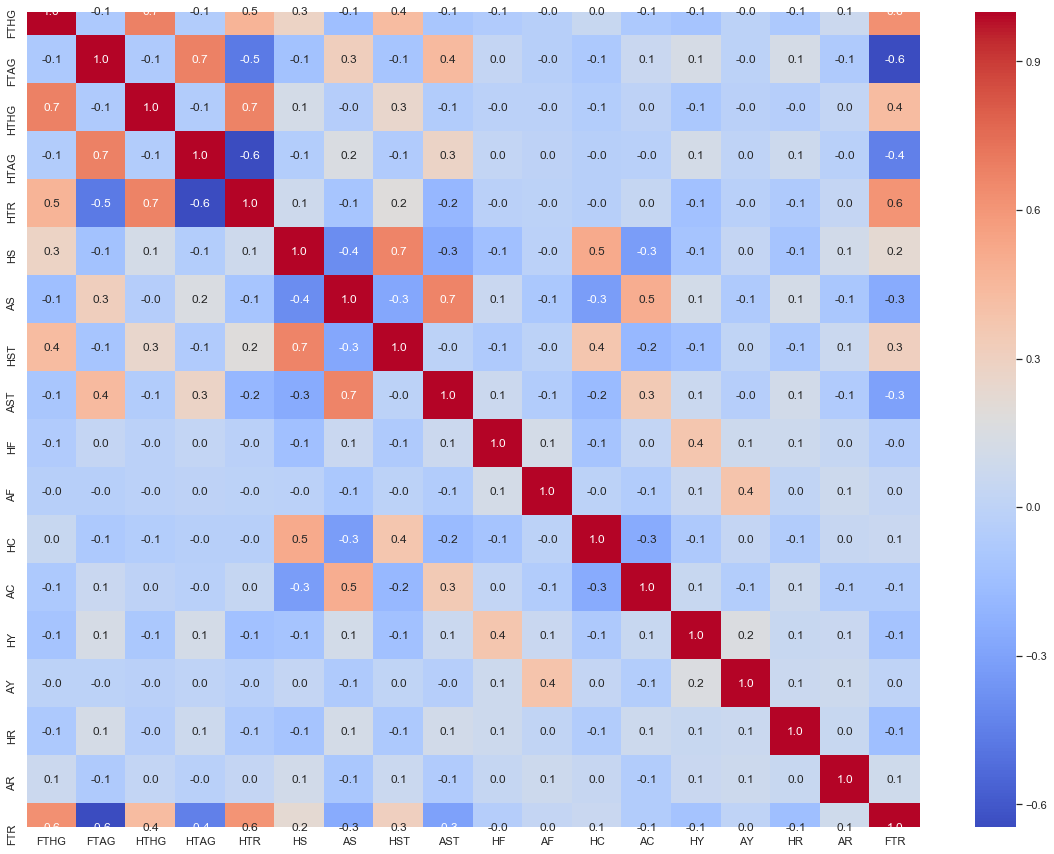

In [91]:
# find out old feat cor.

df_num_oldFeat = df.select_dtypes(include = ['int64']) #only new feats are in float in df currently
plt.figure(figsize=(20,15))
ax=plt.subplot(111)
sns.heatmap(df_num_oldFeat.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax)

In [92]:
df_num_newFeat.dtypes

HAS       float64
HDS       float64
AAS       float64
ADS       float64
FFPTSH    float64
FFHG      float64
FFAG      float64
PSH       float64
SSH       float64
CSH       float64
PSA       float64
SSA       float64
CSA       float64
FTR         int64
dtype: object

# Methodology Overview

## Feature Extraction

# Model Training & Validation

## TRAINING !!!!!

In [126]:
def get_scores(model,X,y):
    '''
    Parameters:
        model
        X
        y
    
    Returns:
    '''
    scores = cross_validate(model, X, y, scoring=('accuracy','f1_macro','precision_macro','recall_macro','roc_auc_ovr'),
                            cv=10, return_train_score=True,n_jobs=n_cpu)
    print('Accuracy: %f'%(scores['test_accuracy'].mean()))
    print('Precision: %f'%(scores['test_precision_macro'].mean()))
    print('Recall: %f'%(scores['test_recall_macro'].mean()))
    print('f1 Score: %f'%(scores['test_f1_macro'].mean()))
    print('ROC-AUC: %f'%(scores['test_roc_auc_ovr'].mean()))
    return scores

def get_best_params_RandomizedCV(model,X,y,param_grid,refit='accuracy'):
    '''
    This function executes the RandomizedSearchCV() to tune the 
    hyperparameters, prints the best scores and returns the list of 
    best performing hyperparameters.
    
    Parameters:
        model
        X
        y
        param_grid
        refit='accuracy'
    
    Returns:
        grid_results.best_params_ (dictionary):
    '''
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = RandomizedSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, y)
    print('Best parameters: \n',grid_results.best_params_)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    print('Best mean %s Score: '%(refit),grid_results.best_score_)
    print('Best mean %s Score: '%(other_scores[0]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best mean %s Score: '%(other_scores[1]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    return grid_results.best_params_

def get_best_params_GridCV(model,X,y,param_grid,refit='accuracy'):
    '''
    This function executes the GridSearchCV() to tune the 
    hyperparameters, prints the best scores and returns the list of 
    best performing hyperparameters.
    
    Parameters:
    model
    X
    y
    param_grid
    refit='accuracy'
    
    Returns:
    grid_results.best_params_ (dictionary):
    '''
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = GridSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, y)
    print('Best parameters: \n',grid_results.best_params_)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    print('Best mean %s Score: '%(refit),grid_results.best_score_)
    print('Best mean %s Score: '%(other_scores[0]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best mean %s Score: '%(other_scores[1]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    return grid_results.best_params_

## feeding data to test the above functions

In [114]:
training_data = df # myMod: ref to a engineered feature df

new_feats_lst = list(df.select_dtypes(include = ['float64']).columns)
wanted_feats = new_feats_lst + ['HomeTeam', 'AwayTeam'] 
X=training_data[[column for column in training_data.columns if column in wanted_feats]]
# y=training_data['FTR']

# encode the remaining text feat.s
from sklearn.preprocessing import LabelEncoder,StandardScaler,scale,MinMaxScaler
enc = LabelEncoder()
for column in ['HomeTeam','AwayTeam']: # encoding list
    X[column]=enc.fit_transform(X[column])
    
X.head()

,HomeTeam,AwayTeam,HAS,HDS,AAS,ADS,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,0,32,1.356923,0.711075,0.769196,1.358580,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657
1,5,27,0.880000,1.292399,0.674295,1.402534,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657
2,12,3,1.101538,0.919493,0.865345,1.820597,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657
3,15,13,0.724308,1.303637,0.667873,1.387121,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657
4,20,30,0.575385,0.966490,1.356763,1.144258,1.645014,1.533657,1.142521,1.645014,1.533657,1.142521,1.102355,1.142521,1.533657


### Logistic Regression Classifier 

In [153]:
model = LogisticRegression(n_jobs=n_cpu)
scores_LR=get_scores(model,X,y)


Accuracy: 0.537799
Precision: 0.352447
Recall: 0.452095
f1 Score: 0.391953
ROC-AUC: 0.673184


In [118]:
param_grid={'penalty':['l1','l2','elasticnet']}
best_params_LR=get_best_params_GridCV(model_LR,X,y,param_grid,refit='accuracy')

Best parameters: 
 {'penalty': 'l2'}
Best mean accuracy Score:  0.5377990430622008
Best mean f1_macro Score:  0.39195267450927523
Best mean roc_auc_ovr Score:  0.39195267450927523


### k-NN Classifier

In [138]:
model = KNeighborsClassifier(n_neighbors=5,n_jobs=n_cpu)
scores_knn = get_scores(model,X,y)

Accuracy: 0.450478
Precision: 0.415706
Recall: 0.421855
f1 Score: 0.415139
ROC-AUC: 0.600220


### Support Vector Machine Classifier

In [137]:
from sklearn.svm import SVC

# poly kernel
model_svm = SVC(kernel='poly', degree=8, probability=True)
scores_svm = get_scores(model_svm,X,y)

Accuracy: 0.482057
Precision: 0.360727
Recall: 0.366292
f1 Score: 0.288922
ROC-AUC: 0.601602


In [143]:
# poly kernel 2 degrees
model_svm = SVC(kernel='poly', degree=2, probability=True)
scores_svm = get_scores(model_svm,X,y)

Accuracy: 0.500718
Precision: 0.345683
Recall: 0.389882
f1 Score: 0.323245
ROC-AUC: 0.623263


In [144]:
# poly kernel
model_svm = SVC(kernel='sigmoid', probability=True)
scores_svm = get_scores(model_svm,X,y)

Accuracy: 0.338756
Precision: 0.333959
Recall: 0.342718
f1 Score: 0.325380
ROC-AUC: 0.500207


In [145]:
# poly kernel
model_svm = SVC(kernel='rbf', probability=True)
scores_svm = get_scores(model_svm,X,y)

Accuracy: 0.512440
Precision: 0.347792
Recall: 0.410200
f1 Score: 0.351204
ROC-AUC: 0.621358


### Gaussian Naive Bayes Classifier

In [147]:
from sklearn.naive_bayes import GaussianNB

model=GaussianNB()
scores_GNB = get_scores(model_svm,X,y)

Accuracy: 0.512440
Precision: 0.347792
Recall: 0.410200
f1 Score: 0.351204
ROC-AUC: 0.622118


### SGD Classifier

In [150]:
from sklearn.linear_model import SGDClassifier

model_sgd = SGDClassifier(max_iter=1000000, tol=1e-3)
scores_GNB = get_scores(model,X,y)

Accuracy: 0.521770
Precision: 0.467723
Recall: 0.471576
f1 Score: 0.456541
ROC-AUC: 0.663403


### Multi Layer Perceptron Classifier (Neural Networks)

In [152]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='sgd',activation='identity',learning_rate='adaptive',
                          hidden_layer_sizes=(8, 2), random_state=76)
scores_MLPC = get_scores(model,X,y)

Accuracy: 0.538517
Precision: 0.409833
Recall: 0.452209
f1 Score: 0.396478
ROC-AUC: 0.669014


### Random Forest Classifier

In [151]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,n_jobs=n_cpu)
scores_RFC = get_scores(model,X,y)

Accuracy: 0.506938
Precision: 0.437993
Recall: 0.444463
f1 Score: 0.427004
ROC-AUC: 0.641594


In [ ]:
# model1
model = LogisticRegression(n_jobs=n_cpu)
scores_LR=get_scores(model,X,y)

model = KNeighborsClassifier(n_neighbors=5,n_jobs=n_cpu)
scores_knn = get_scores(model,X,y)

from sklearn.svm import SVC

# poly kernel
model_svm = SVC(kernel='poly', degree=8, probability=True)
scores_svm = get_scores(model_svm,X,y)

# poly kernel 2 degrees
model_svm = SVC(kernel='poly', degree=2, probability=True)
scores_svm = get_scores(model_svm,X,y)

# poly kernel
model_svm = SVC(kernel='sigmoid', probability=True)
scores_svm = get_scores(model_svm,X,y)

# poly kernel
model_svm = SVC(kernel='rbf', probability=True)
scores_svm = get_scores(model_svm,X,y)

from sklearn.naive_bayes import GaussianNB

model=GaussianNB()
scores_GNB = get_scores(model_svm,X,y)

from sklearn.linear_model import SGDClassifier

model_sgd = SGDClassifier(max_iter=1000000, tol=1e-3)
scores_GNB = get_scores(model,X,y)

from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='sgd',activation='identity',learning_rate='adaptive',
                          hidden_layer_sizes=(8, 2), random_state=76)
scores_MLPC = get_scores(model,X,y)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,n_jobs=n_cpu)
scores_RFC = get_scores(model,X,y)

## Compare the models

## Train model with selected features

# Results

# Final Predictions on Test Set

# Conclusion